# Ecological Index - supplementary plots
- Plot future ecological index spatial plots for supplementary
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load data for eco index

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load the Present Day Ecoindex Data

In [7]:
file_in = 'ecoindex_historical_future.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [8]:
# keep some decades
eco_2000_reg = ds_eco.ecoindex_regional_decadal.sel(decades=2000)
eco_2030_reg = ds_eco.ecoindex_regional_decadal.sel(decades=2030)
eco_2060_reg = ds_eco.ecoindex_regional_decadal.sel(decades=2060)
eco_2090_reg = ds_eco.ecoindex_regional_decadal.sel(decades=2090)

### Load the typical polynya data

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [10]:
# Read in jra55 polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_cesm2le_pd = ds_poly.polynya_typical_all_hi

# keep some decades
poly_2000_reg = poly_cesm2le_pd.sel(decades=2000)
poly_2030_reg = poly_cesm2le_pd.sel(decades=2030)
poly_2060_reg = poly_cesm2le_pd.sel(decades=2060)
poly_2090_reg = poly_cesm2le_pd.sel(decades=2090)

### Load SIZ

In [11]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [12]:
# Read in 2000 data
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_mfdataset(dir_in+file_in,decode_times=False)

# get ensemble mean SIC for september in 2000
sic_2000 = ds_siz.SIC_SEP.mean(dim='member_id').sel(time=2000)
sic_2030 = ds_siz.SIC_SEP.mean(dim='member_id').sel(time=2030)
sic_2060 = ds_siz.SIC_SEP.mean(dim='member_id').sel(time=2060)
sic_2090 = ds_siz.SIC_SEP.mean(dim='member_id').sel(time=2090)
# make array to fill
siz_2000 = sic_2000.where(sic_2000 == 1, other = 1)
siz_2030 = sic_2030.where(sic_2030 == 1, other = 1)
siz_2060 = sic_2060.where(sic_2060 == 1, other = 1)
siz_2090 = sic_2090.where(sic_2090 == 1, other = 1)
# keep only SIZ data
siz_2000 = siz_2000.where(sic_2000 >= 0.15,other=0)
siz_2030 = siz_2030.where(sic_2030 >= 0.15,other=0)
siz_2060 = siz_2060.where(sic_2060 >= 0.15,other=0)
siz_2090 = siz_2090.where(sic_2090 >= 0.15,other=0)
# mask land
siz_2000 = siz_2000.where(ds_grid.REGION_MASK == 1)
siz_2030 = siz_2030.where(ds_grid.REGION_MASK == 1)
siz_2060 = siz_2060.where(ds_grid.REGION_MASK == 1)
siz_2090 = siz_2090.where(ds_grid.REGION_MASK == 1)

### Mask ecoindex outside SIZ

In [13]:
# mask where it's out of SIZ
eco_2000_reg = eco_2000_reg.where(siz_2000 == 1)
eco_2030_reg = eco_2030_reg.where(siz_2030 == 1)
eco_2060_reg = eco_2060_reg.where(siz_2060 == 1)
eco_2090_reg = eco_2090_reg.where(siz_2090 == 1)

### Load regional masks

In [14]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [15]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load shapefiles

In [16]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [17]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures - contours

In [18]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [19]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### Set plotting ranges, etc.
- All EcoIndex values go from 0 to 1

In [20]:
# set some plotting info
cmap_in = cmocean.cm.deep
vmin_in = 0.0
vmax_in = 1.0
# set contour levels
levels_in = np.arange(0,1.1,0.1)
levels_in_poly = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
levels_in_aev = np.arange(0.6,0.7,0.1)
units = ' '
title = 'AEV Index'

### Save plot

In [21]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_5/'

### Plot 2000 Regional EcoIndex

In [22]:
fout = 'Fig_supp_Ecoindex_regional_2000'
data_plt = eco_2000_reg
data_poly = poly_2000_reg

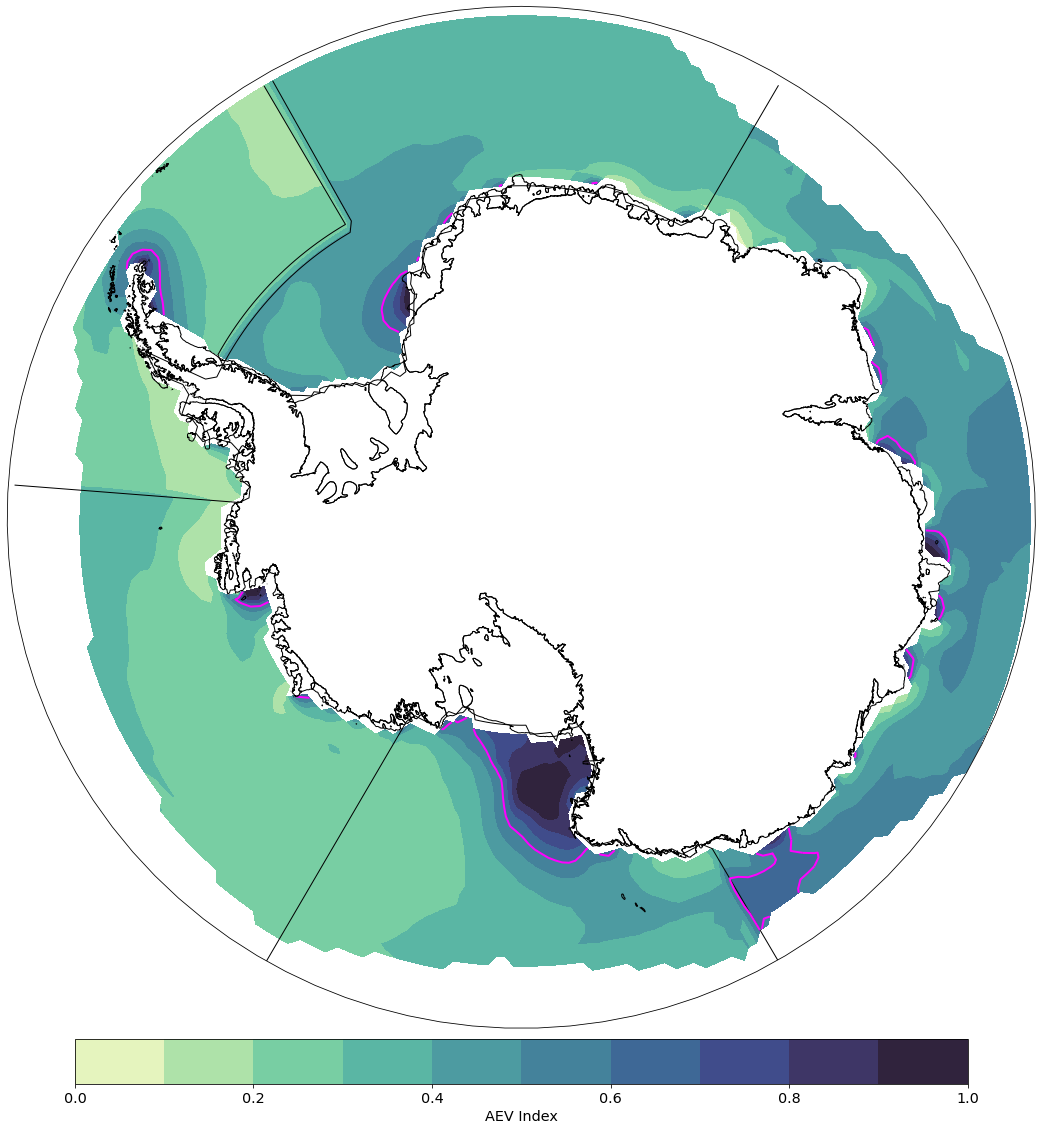

In [23]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('AEV Index',fontsize='x-large')

### Add regional domain lines
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_1_mod').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Overlay AEV 0.6 bin line
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=2,
                 levels=levels_in_aev,
                 transform=ccrs.PlateCarree()) 

### Overlay polynyas
#lon, lat, field = utils.adjust_pop_grid(lons,lats,data_poly.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='m',linestyles='solid',linewidths=3,
#                 levels=levels_in_poly,
#                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Plot 2030 Regional EcoIndex

In [24]:
fout = 'Fig_supp_Ecoindex_regional_2030'
data_plt = eco_2030_reg
data_poly = poly_2030_reg

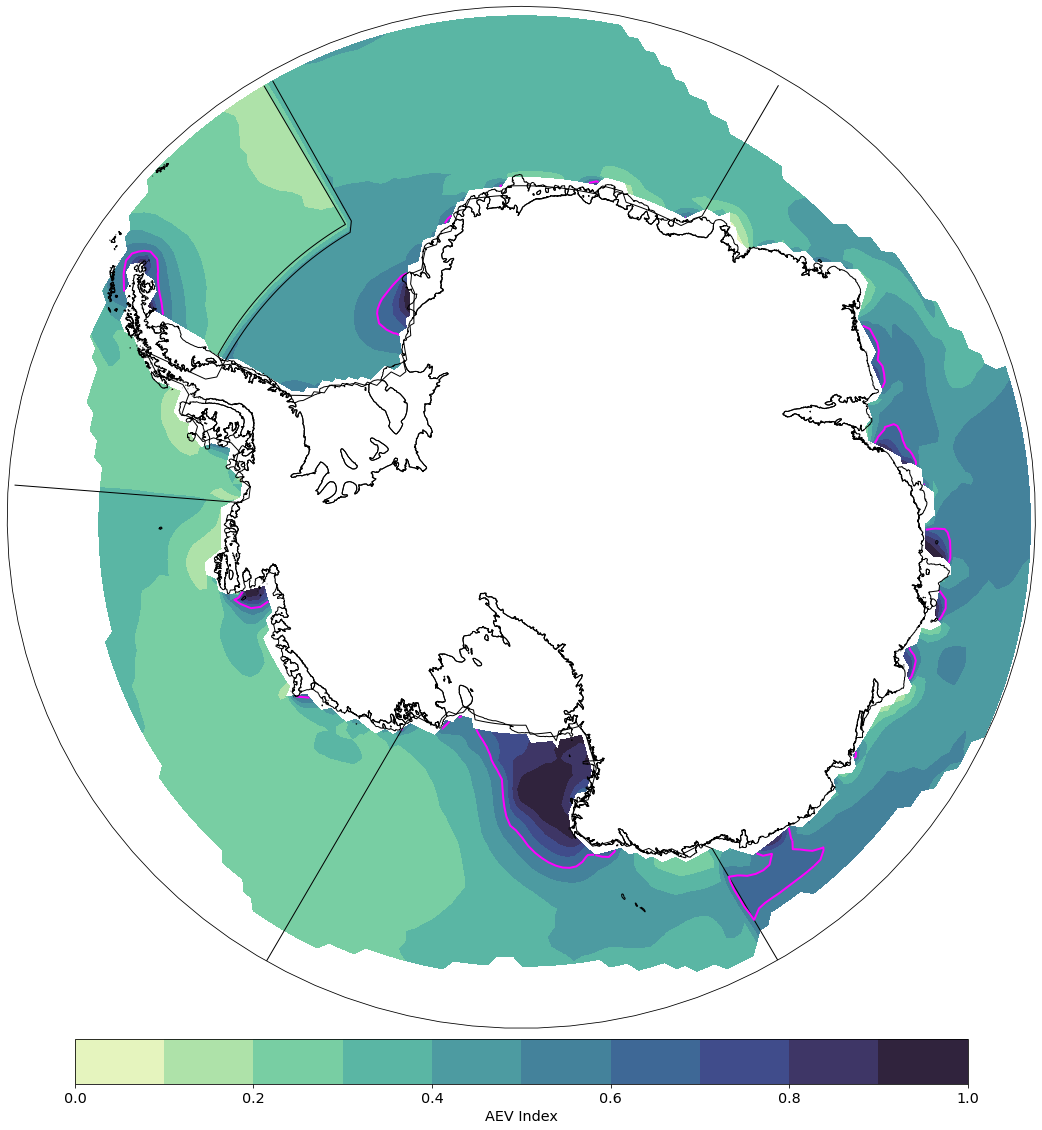

In [25]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('AEV Index',fontsize='x-large')

### Add regional domain lines
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_1_mod').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Overlay AEV 0.6 bin line
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=2,
                 levels=levels_in_aev,
                 transform=ccrs.PlateCarree()) 

### Overlay polynyas
#lon, lat, field = utils.adjust_pop_grid(lons,lats,data_poly.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='m',linestyles='solid',linewidths=3,
#                 levels=levels_in_poly,
#                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Plot 2060 Regional EcoIndex

In [26]:
fout = 'Fig_supp_Ecoindex_regional_2060'
data_plt = eco_2060_reg
data_poly = poly_2060_reg

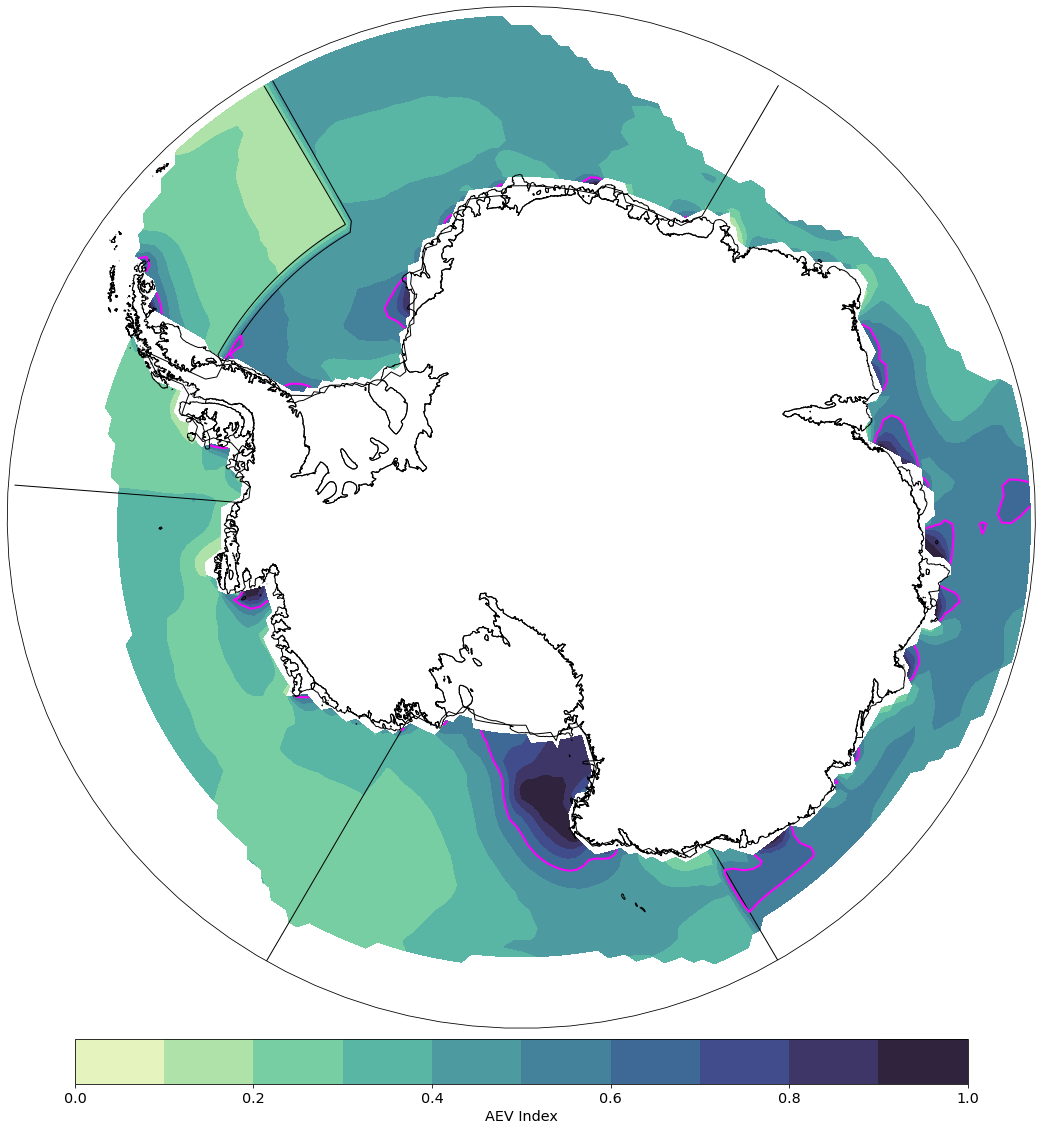

In [27]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('AEV Index',fontsize='x-large')

### Add regional domain lines
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_1_mod').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Overlay AEV 0.6 bin line
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=2,
                 levels=levels_in_aev,
                 transform=ccrs.PlateCarree()) 

### Overlay polynyas
#lon, lat, field = utils.adjust_pop_grid(lons,lats,data_poly.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='m',linestyles='solid',linewidths=3,
#                 levels=levels_in_poly,
#                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Plot 2090 Regional EcoIndex

In [28]:
fout = 'Fig_supp_Ecoindex_regional_2090'
data_plt = eco_2090_reg
data_poly = poly_2090_reg

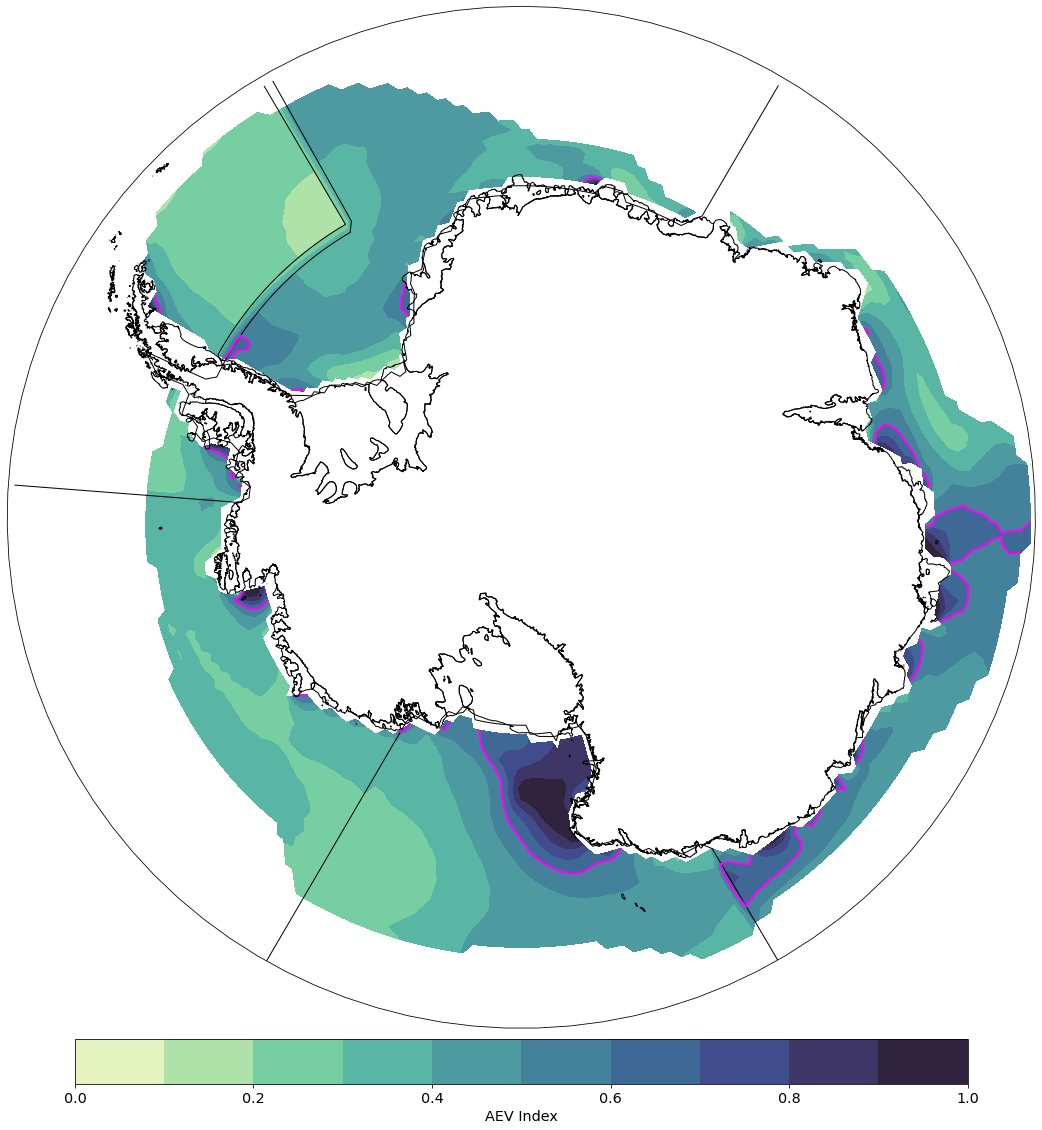

In [29]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('AEV Index',fontsize='x-large')

### Add regional domain lines
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_1_mod').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Overlay AEV 0.6 bin line
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=2,
                 levels=levels_in_aev,
                 transform=ccrs.PlateCarree()) 

### Overlay polynyas
#lon, lat, field = utils.adjust_pop_grid(lons,lats,data_poly.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='m',linestyles='solid',linewidths=3,
#                 levels=levels_in_poly,
#                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)